# 🧠 Brain MRI Image Alzheimer Classifier 🧠
In this notebook we will classify T1-weighted MRI images from healthy and dementia patients

## First: Install Weights and Biases
Be Sure your Kernel (in the top right of Jupyter Notebook) is set to: `Tensorflow-2.7.0`

If this is your first time installing WANDB, it will install and restart your kernel (an error will pop up).

Clear the pop-up window and just rerun all the cells below.

In [1]:
import os, sys
sys.path.append(os.path.join(os.environ['HOME'],'.local','bin'))
try:
    import wandb as wb # Import Weights and Biases
except:
    !pip install wandb
    os._exit(0) # Restart Jupyter Kernel

## Next: Import all of your Python Packages

In [2]:
import warnings, shutil, random
from wandb.keras import WandbMetricsLogger
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

from tensorflow import keras
import tensorflow as tf

print("TensorFlow Version:", tf.__version__)
wb.login(); # USE YOUR API KEY TO LOGIN BELOW

TensorFlow Version: 2.7.0


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aalbizu (woodslab). Use `wandb login --relogin` to force relogin


## Here, we will define our settings for this experiment

In [3]:
class config:
    
    # specify the paths to datasets
    DOWNLOAD_DIR = Path(os.path.join(os.getcwd(),'input','Dataset'))
    ROOT_DIR = Path(os.path.join(os.getcwd(),'input'))
    TRAIN_DIR = ROOT_DIR.joinpath('train')
    TEST_DIR = ROOT_DIR.joinpath('test')
    VAL_DIR = ROOT_DIR.joinpath('val')

    # set the input height and width
    IMG_HEIGHT = 128
    IMG_WIDTH = 128
    
    NUM_EPOCHS = 20
    BATCH_SIZE = 64

# Initialize Weights and Biases
wb.init(project="wandb-tutorial",
           config={
               "batch_size": config.BATCH_SIZE,
               "n_epoch": config.NUM_EPOCHS,
               "image_size": [config.IMG_HEIGHT, config.IMG_WIDTH],
               "dataset": "kaggle",
           }
       )

## Next, we need to split our data into Training / Validation / Testing
The Model is training on the `training data` and performance is checked with the `validation data`

Once the model is trained, we can check the model performance with the `test data`

Found 6389 files belonging to 4 classes.


2023-10-09 15:29:16.779956: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 15:29:17.504502: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78911 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:87:00.0, compute capability: 8.0


Found 2220 files belonging to 4 classes.
Found 2204 files belonging to 4 classes.

Class names: ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']



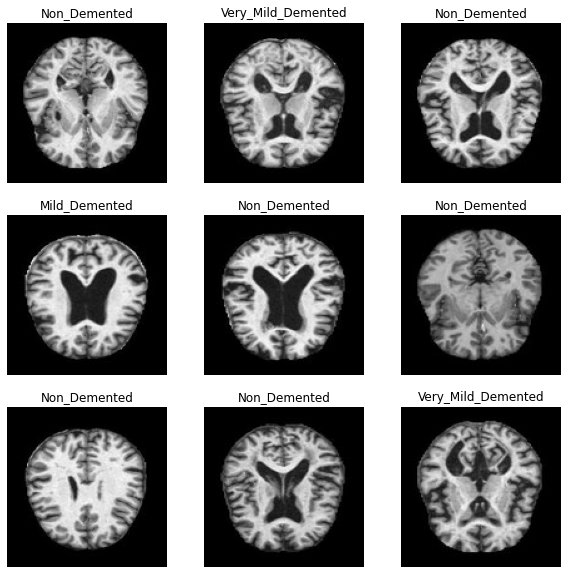

In [4]:
def split_and_copy_files(src_dir, dst_dirs):
    # List all files recursively
    all_files = [os.path.join(root, f) for root, dirs, files in os.walk(src_dir) for f in files]
    
    # Shuffle the list
    random.shuffle(all_files)
    
    # Split the files into three parts
    total_files = len(all_files)
    split1 = int(0.8 * total_files)
    split2 = int(0.9 * total_files)
    
    files_80 = all_files[:split1]
    files_10a = all_files[split1:split2]
    files_10b = all_files[split2:]
    
    # Copy files to the new locations
    for i, files in enumerate([files_80, files_10a, files_10b]):
        dst_dir = dst_dirs[i]
        os.makedirs(dst_dir, exist_ok=True)
        for file in files:
            classname = os.path.basename(os.path.dirname(file))
            if not os.path.exists(os.path.join(dst_dir, classname, os.path.basename(file))):
                os.makedirs(os.path.join(dst_dir, classname),exist_ok=True)
                shutil.copy(file, os.path.join(dst_dir, classname, os.path.basename(file)))

# Define the source directory and destination directories
dst_dirs = [config.TRAIN_DIR, config.VAL_DIR, config.TEST_DIR]

# Call the function
split_and_copy_files(config.DOWNLOAD_DIR, dst_dirs)

# Training Data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
dst_dirs[0],
seed=42,
image_size=(config.IMG_HEIGHT, config.IMG_WIDTH),
batch_size=64
)

# Validation Data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
dst_dirs[1],
seed=42,
image_size=(config.IMG_HEIGHT, config.IMG_WIDTH),
batch_size=64
)

# Testing Data
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
dst_dirs[2],
seed=42,
image_size=(config.IMG_HEIGHT, config.IMG_WIDTH),
batch_size=64
)

# Plot
class_names = train_ds.class_names
print(f'\nClass names: {class_names}\n')
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Now that we have our data sorted, lets check out the class imbalance
We will plot the frequency of each class

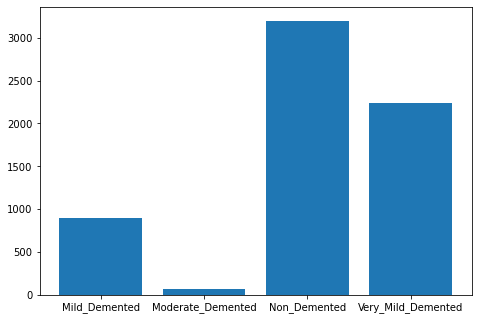

In [5]:
# Plot
fig = plt.figure();
ax = fig.add_axes([0,0,1,1]);
size = [896,64,3200,2240] # I just hardcoded this from kaggle (try to write some code to compute this directly)
ax.bar(class_names,size);
plt.show;

## With our data ready, we can construct our convolutional neural network 🤖

In [6]:
# Construct Model
model = keras.models.Sequential()
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(config.IMG_HEIGHT,config.IMG_WIDTH, 3)))
model.add(keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.20))
model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(64,"relu"))
model.add(keras.layers.Dense(4,"softmax"))

## "Every neural network would be lost with a loss function" - Socrates

In [7]:
# Define Loss
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "Adam",metrics=["accuracy"])

## Now, we can see what our model looks like 👀

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0

## What are we wating for, lets start training ! 💪
Batch size = 64 and Epochs = 20 

These settings are totally arbitrary but you can try messing with them to see if you get better performance (if you have time)

In [9]:
# Train
hist = model.fit(train_ds,validation_data=val_ds,epochs=config.NUM_EPOCHS, batch_size=config.BATCH_SIZE, callbacks=[WandbMetricsLogger()], verbose=1)

Epoch 1/20


2023-10-09 15:29:22.118723: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2023-10-09 15:29:23.806185: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


100/100 [==============================] - 5s 17ms/step - loss: 1.1717 - accuracy: 0.4938 - val_loss: 0.9864 - val_accuracy: 0.5617
Epoch 2/20
100/100 [==============================] - 2s 15ms/step - loss: 0.9215 - accuracy: 0.5616 - val_loss: 0.8692 - val_accuracy: 0.6032
Epoch 3/20
100/100 [==============================] - 2s 15ms/step - loss: 0.8169 - accuracy: 0.6244 - val_loss: 0.7973 - val_accuracy: 0.6694
Epoch 4/20
100/100 [==============================] - 2s 15ms/step - loss: 0.7131 - accuracy: 0.6776 - val_loss: 0.6028 - val_accuracy: 0.7486
Epoch 5/20
100/100 [==============================] - 2s 15ms/step - loss: 0.6077 - accuracy: 0.7324 - val_loss: 0.5078 - val_accuracy: 0.8207
Epoch 6/20
100/100 [==============================] - 2s 15ms/step - loss: 0.4834 - accuracy: 0.7903 - val_loss: 0.3201 - val_accuracy: 0.8955
Epoch 7/20
100/100 [==============================] - 2s 15ms/step - loss: 0.3575 - accuracy: 0.8574 - val_loss: 0.1652 - val_accuracy: 0.9680
Epoch 8/20

## What even happen during training ? 😴
Lets make some plots to find out !

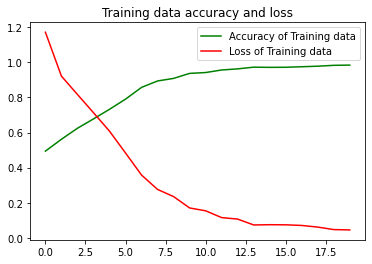

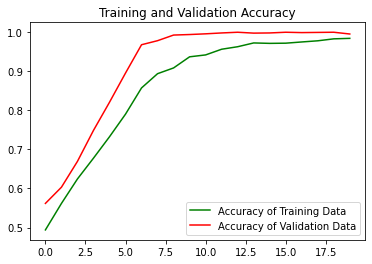

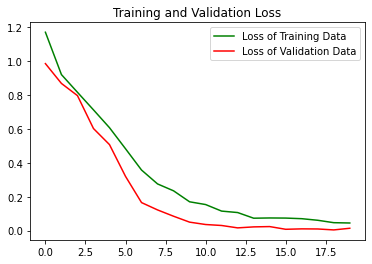

<Figure size 432x288 with 0 Axes>

In [10]:
get_ac = hist.history['accuracy']
get_los = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

epochs = range(len(get_ac))
plt.plot(epochs, get_ac, 'g', label='Accuracy of Training data')
plt.plot(epochs, get_los, 'r', label='Loss of Training data')
plt.title('Training data accuracy and loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_los, 'g', label='Loss of Training Data')
plt.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

## But what about the test data ? 🤔🤔
Does this model even work on untrained data

35/35 [==============================] - 1s 13ms/step - loss: 0.0136 - accuracy: 0.9973


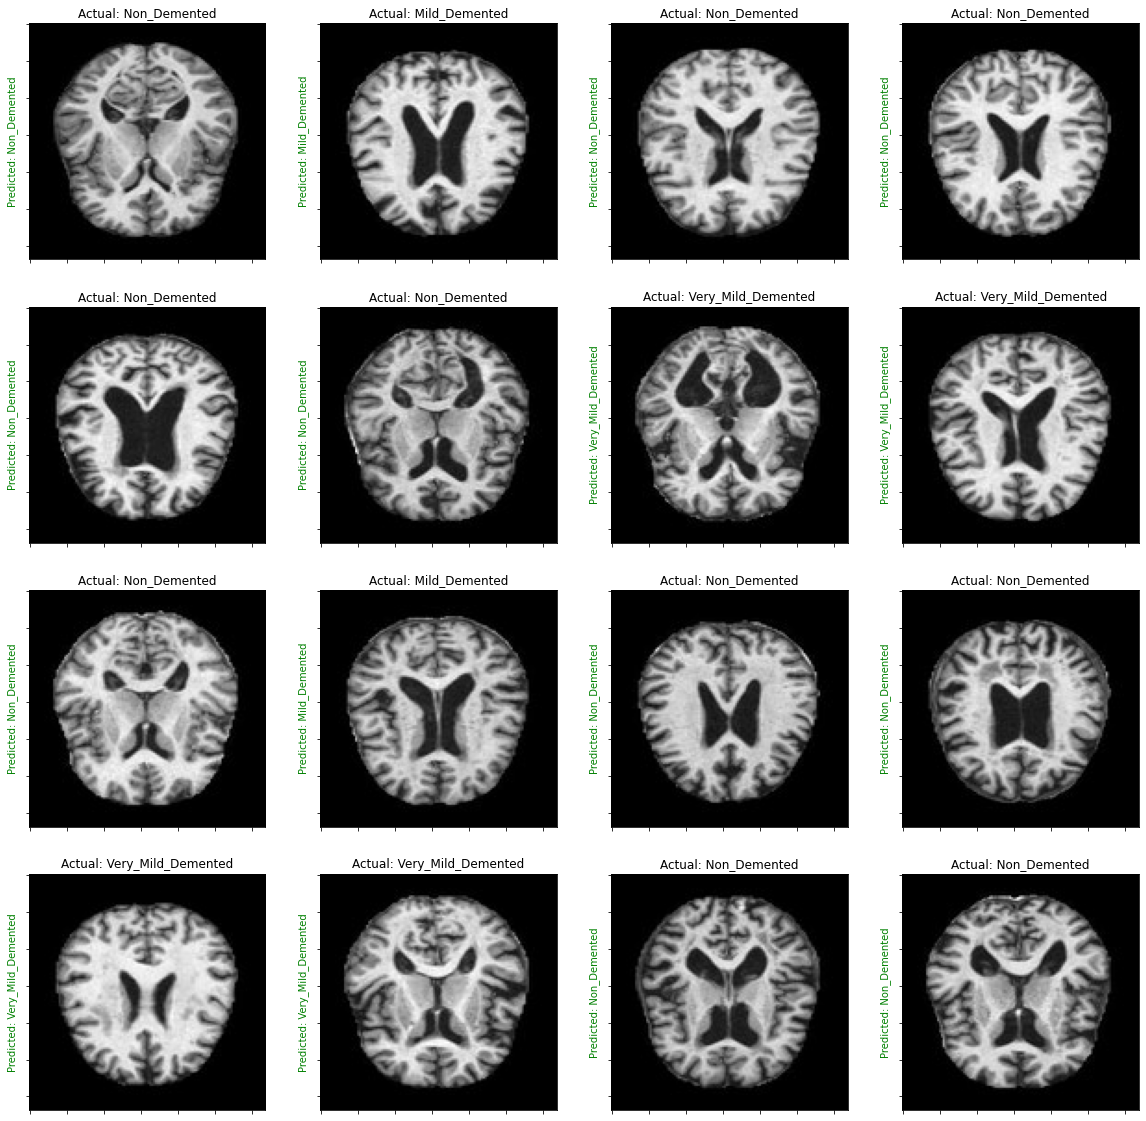

In [11]:
loss, accuracy = model.evaluate(test_ds,callbacks=[WandbMetricsLogger()])

plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'green'})
            
        else:
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'red'})
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])

# ✨ TA-DA ! ✨ You have created a robot neurologist 🎉
(Not Really...)

Since these are 2D images, this thing is completely worthless but it was fun anyway

Its about the journey, not the destination 🌈

byeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee